In [ ]:
pip install boto3 pandas py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 7.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import boto3
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import os
import pandas as pd
from PIL import Image

In [ ]:
# Step 3: Connect to S3 with credentials and download the dataset
s3 = boto3.client(
    's3',
    aws_access_key_id='your Access Key',                         # Replace with your AWS Access Key
    aws_secret_access_key='your Secret Access Key'               # Replace with your AWS Secret Key
)

In [ ]:
bucket_name = 'cifar-10-folder'  # Replace with your S3 bucket name
zip_key = 'cifar-10.zip'         # Path to your zip file in S3 (e.g., 'path/to/cifar-10.zip')
local_zip_path = '/content/cifar-10.zip'
extracted_path = '/content/cifar-10'
s3.download_file(bucket_name, zip_key, local_zip_path)
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)
print("Extracted contents:", os.listdir(extracted_path))

Extracted contents: ['sampleSubmission.csv', 'train.7z', 'test.7z', 'trainLabels.csv']


In [ ]:
# Download the zip file from S3
print("Connecting to S3 and downloading dataset...")
try:
    s3.download_file(bucket_name, zip_key, local_zip_path)
    print(f"Successfully downloaded {zip_key} from {bucket_name}")
except Exception as e:
    print(f"Error downloading from S3: {e}")
    raise

Connecting to S3 and downloading dataset...
Successfully downloaded cifar-10.zip from cifar-10-folder


In [ ]:
import py7zr

print("Extracting dataset...")
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)
print("Extracted contents:", os.listdir(extracted_path))

# Extract the .7z files
print("Extracting train.7z and test.7z...")
train_7z_path = os.path.join(extracted_path, 'train.7z')
with py7zr.SevenZipFile(train_7z_path, 'r') as archive:
    archive.extractall(path=extracted_path)
print(f"Extracted {train_7z_path}")

test_7z_path = os.path.join(extracted_path, 'test.7z')
with py7zr.SevenZipFile(test_7z_path, 'r') as archive:
    archive.extractall(path=extracted_path)
print(f"Extracted {test_7z_path}")

# Verify the extracted contents
print("Updated contents:", os.listdir(extracted_path))

Extracting dataset...
Extracted contents: ['sampleSubmission.csv', 'train.7z', 'test.7z', 'trainLabels.csv']
Extracting train.7z and test.7z...
Extracted /content/cifar-10/train.7z
Extracted /content/cifar-10/test.7z
Updated contents: ['test', 'sampleSubmission.csv', 'train.7z', 'train', 'test.7z', 'trainLabels.csv']


In [ ]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Custom Dataset Class
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, image_dir, labels_file=None, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck']
        if labels_file:
            self.labels_df = pd.read_csv(labels_file)
            self.image_files = [str(id) + '.png' for id in self.labels_df['id']]
            self.labels = [self.classes.index(label) for label in self.labels_df['label']]
        else:
            self.image_files = sorted(os.listdir(image_dir))
            self.labels = None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label            # If labels exist, returns a tuple of (image, label).
        return image                       # Otherwise, returns only the image.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),                                  # Converts PIL images to PyTorch tensors (range [0, 1]).
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes the tensor
])

In [ ]:
# Load full training dataset
train_dir = '/content/cifar-10/train'
labels_file = '/content/cifar-10/trainLabels.csv'
full_train_dataset = CustomCIFAR10Dataset(train_dir, labels_file, transform=transform) # Creates a dataset instance for training data with labels and transformations.

In [ ]:
# Load test dataset
test_dir = '/content/cifar-10/test'
test_dataset = CustomCIFAR10Dataset(test_dir, transform=transform)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Create DataLoaders
batch_size = 128
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define Teacher Model
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  #(3 input channels (RGB), 32 output channels, 3x3 kernel, padding=1.)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #(32 input channels, 64 output channels.)
        self.pool = nn.MaxPool2d(2, 2)                           #(layer with 2x2 kernel and stride 2.)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)                    #(input size 64x8x8 (after convolutions and pooling), output size 512.)
        self.fc2 = nn.Linear(512, 10)                            #(output size 10 (one per CIFAR-10 class))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                     #(Applies conv1, ReLU activation, and pooling)
        x = self.pool(F.relu(self.conv2(x)))                     #(Applies conv2, ReLU, and pooling.)
        x = x.view(-1, 64 * 8 * 8)                               #(Flattens the tensor to shape)
        x = F.relu(self.fc1(x))                                  #(Applies the first fully connected layer with ReLU)
        x = self.fc2(x)                                          #(Applies the second fully connected layer.)
        return x                                                 #(output logits)

In [ ]:
# Train Teacher Model
teacher = TeacherModel().to(device)
criterion = nn.CrossEntropyLoss()                       # Defines the loss function
optimizer = optim.Adam(teacher.parameters(), lr=0.001)  # Sets up the Adam optimizer with a learning rate of 0.001.

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data                                  # Unpacks the batch into images and labels
            inputs, labels = inputs.to(device), labels.to(device)  # Moves data to the device
            optimizer.zero_grad()                                  # Clears previous gradients.
            outputs = model(inputs)                                # Computes model predictions.
            loss = criterion(outputs, labels)                      # Calculates the loss.
            loss.backward()
            optimizer.step()                                       # Updates model weights.
            running_loss += loss.item()                            # Adds the batch loss to the running total.
        print(f'Teacher Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}')

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)       # Gets the predicted class indices.
                total += labels.size(0)                         # Adds the batch size to the total.
                correct += (predicted == labels).sum().item()   # Counts correct predictions.
        print(f'Teacher Validation Accuracy: {100 * correct / total}%')

In [ ]:
train_model(teacher, trainloader, valloader, criterion, optimizer, epochs=10)

# Save Teacher Model
torch.save(teacher.state_dict(), '/content/teacher_model.pth')

Teacher Epoch 1, Loss: 1.4078150583913152
Teacher Validation Accuracy: 58.89%
Teacher Epoch 2, Loss: 1.0240199364031466
Teacher Validation Accuracy: 62.75%
Teacher Epoch 3, Loss: 0.8485784155492204
Teacher Validation Accuracy: 66.32%
Teacher Epoch 4, Loss: 0.7164014269368717
Teacher Validation Accuracy: 69.45%
Teacher Epoch 5, Loss: 0.5795570778580138
Teacher Validation Accuracy: 71.5%
Teacher Epoch 6, Loss: 0.4499338159736353
Teacher Validation Accuracy: 70.23%
Teacher Epoch 7, Loss: 0.31926864480819944
Teacher Validation Accuracy: 71.19%
Teacher Epoch 8, Loss: 0.20550964815548053
Teacher Validation Accuracy: 71.1%
Teacher Epoch 9, Loss: 0.1293767948215381
Teacher Validation Accuracy: 70.48%
Teacher Epoch 10, Loss: 0.07968016717428217
Teacher Validation Accuracy: 71.01%


In [ ]:
# Define Student Model
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc1(x)
        return x

In [ ]:
# Set up distillation parameters
T = 2.0  # Temperature for softening probabilities
alpha = 0.5  # Weight for distillation loss

In [ ]:
# Train Student with Distillation
student = StudentModel().to(device)    # Instantiates the student model and moves it to the device.
optimizer_s = optim.Adam(student.parameters(), lr=0.001)  # Sets up the optimizer for the student.

In [ ]:
# Load pre-trained teacher
teacher.load_state_dict(torch.load('/content/teacher_model.pth'))  # Loads the pre-trained teacher model’s parameters.
teacher.eval()                                                     # Sets the teacher to evaluation mode.

<ipython-input-45-93a0f5a03b60>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('/content/teacher_model.pth'))


TeacherModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
def distillation_loss(student_output, teacher_output, labels, T, alpha):
    """Compute the distillation loss combining hard and soft targets."""
    loss_hard = F.cross_entropy(student_output, labels)    # Computes the standard cross-entropy loss with hard labels.
    loss_soft = nn.KLDivLoss(reduction='batchmean')(       # Computes the KL divergence between softened student and teacher outputs:
        F.log_softmax(student_output / T, dim=1),          # Softens student logits with temperature.
        F.softmax(teacher_output / T, dim=1)               # Softens teacher logits.
    )
    return (1 - alpha) * loss_hard + alpha * (T**2) * loss_soft     # Combines hard and soft losses, scaling the soft loss by T**2

In [ ]:
for epoch in range(10):
    student.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_s.zero_grad()
        with torch.no_grad():
            teacher_output = teacher(inputs)            # Gets teacher predictions.
        student_output = student(inputs)                # Gets student predictions.
        loss = distillation_loss(student_output, teacher_output, labels, T, alpha)     # Computes the distillation loss.
        loss.backward()
        optimizer_s.step()
        running_loss += loss.item()
    print(f'Student Epoch {epoch+1}, Loss: {running_loss / len(trainloader)}')

    # Evaluates the student on the validation set (same as teacher validation).
    student.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = student(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Student Validation Accuracy: {100 * correct / total}%')

Student Epoch 1, Loss: 1.8086134241031
Student Validation Accuracy: 61.23%
Student Epoch 2, Loss: 1.7702431396935314
Student Validation Accuracy: 61.21%
Student Epoch 3, Loss: 1.7376197637460482
Student Validation Accuracy: 61.39%
Student Epoch 4, Loss: 1.7027825878831906
Student Validation Accuracy: 61.57%
Student Epoch 5, Loss: 1.6741983330668733
Student Validation Accuracy: 61.98%
Student Epoch 6, Loss: 1.6487963291021963
Student Validation Accuracy: 62.01%
Student Epoch 7, Loss: 1.61771988449767
Student Validation Accuracy: 62.08%
Student Epoch 8, Loss: 1.5945967352047514
Student Validation Accuracy: 61.83%
Student Epoch 9, Loss: 1.5733300036134812
Student Validation Accuracy: 62.46%
Student Epoch 10, Loss: 1.5574714947051513
Student Validation Accuracy: 62.49%


Sample Predictions (logits for first 5 test images): tensor([[-2.7793, -6.0313,  2.9771,  1.2745,  1.2803,  2.6682, -2.6175, -6.3022,
         -5.1657, -9.8908],
        [-2.1333, -4.5994, -2.1882, -0.2146, -1.9176,  0.7456, -3.2040, -1.8253,
         -2.5212, -5.7766],
        [-2.8640, -5.7241,  4.9111, -0.9644,  5.5295,  1.0864,  2.6348,  0.8047,
         -8.5559, -6.6812],
        [-3.2018, -4.4935,  0.1270, -4.5156,  0.8762, -3.9375,  0.2410, -0.0278,
         -7.2973, -4.0741],
        [-2.5879, -6.4850,  2.3283,  0.2668,  1.8843, -0.5697,  3.7025, -2.1559,
         -8.4975, -5.3947]], device='cuda:0')

Predicted Labels for First 5 Test Images:
   id predicted_label
0   1            bird
1   2             dog
2   3            deer
3   4            deer
4   5            frog


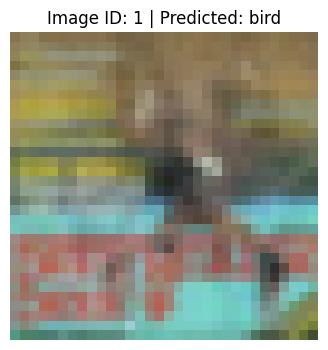

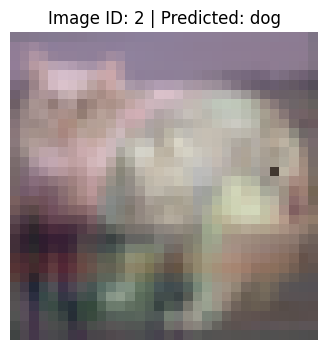

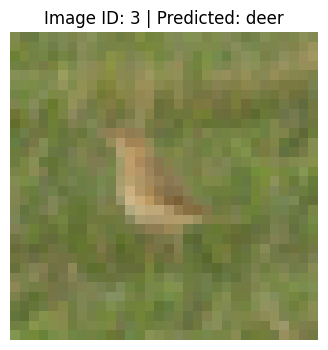

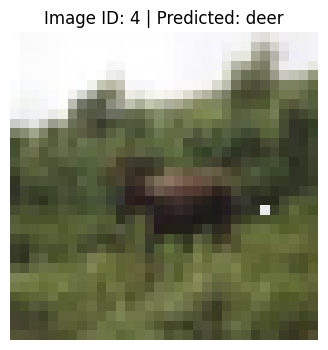

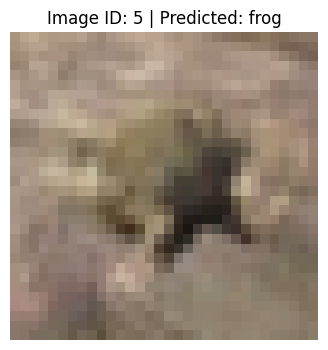

In [ ]:
# Generate predictions on test set and display sample images
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Define CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
student.eval()        # Sets the student to evaluation mode.
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images = data  # Test dataset returns only images
        images = images.to(device)
        outputs = student(images)
        predicted_classes = torch.argmax(outputs, dim=1)  # Get predicted class indices
        if i == 0:  # Process first batch
            # Print original logits for reference
            print('Sample Predictions (logits for first 5 test images):', outputs[:5])

            # Create DataFrame with image IDs and predicted labels
            batch_size = images.size(0)
            image_ids = list(range(1, batch_size + 1))  # Assuming IDs start from 1
            predicted_labels = [class_names[idx.item()] for idx in predicted_classes]
            df = pd.DataFrame({'id': image_ids, 'predicted_label': predicted_labels})
            print("\nPredicted Labels for First 5 Test Images:")
            print(df.head(5))

            # Move images to CPU and unnormalize for display
            images_cpu = images.cpu()
            # Assuming normalization with mean=0.5, std=0.5 per channel
            images_unnormalized = images_cpu * 0.5 + 0.5  # Scale from [-1,1] to [0,1]
            images_unnormalized = images_unnormalized.numpy()

            # Display first 5 images with predicted labels
            for j in range(5):
                img = images_unnormalized[j].transpose(1, 2, 0)  # Change from CxHxW to HxWxC
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.title(f'Image ID: {image_ids[j]} | Predicted: {predicted_labels[j]}')
                plt.axis('off')
                plt.show()
            break
